In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



# 1. Hyperparameter tuning

In [2]:
X_train_df = pd.read_csv('data/train_features.csv')
X_test_df = pd.read_csv('data/test_features.csv')
y_train = pd.read_csv('data/train_target.csv')
y_test = pd.read_csv('data/test_target.csv')

## 1.1 Pipeline settings and search space

In [3]:
import imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn import __version__ as imblearn_version
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek


from sklearn import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, make_scorer,precision_recall_curve, precision_score, recall_score, roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


## Part of this code for pipeling creation and model training was adapted from: https://ryan-reilly.medium.com/gridsearch-pipelines-of-multiple-models-on-multiclass-classification-e9124b6ea2e3

##1. Experiment 1: Training models with imbalanced data
pipe_lr_imb = Pipeline([('LR', LogisticRegression(random_state=31))])
pipe_svm_imb = Pipeline([('SVM', SVC(probability=True,random_state=31))])
pipe_xgb_imb = Pipeline([('XGB', xgb.XGBClassifier(random_state=31))])
pipe_lgbm_imb =Pipeline([('LGBM', LGBMClassifier(verbosity=-1,random_state=31))]) ## Need input

##For resampling, the imblearn library will be used to integrate resampling step with the pipeline
## 2. Experiment 2: Training models with data resampledby using SMOTE (Oversampling)

pipe_lr_os = Pipeline([('resampling', SMOTE(k_neighbors=5, random_state=31)), 
                       ('LR', LogisticRegression(random_state=31))])
pipe_svm_os = Pipeline([('resampling', SMOTE(k_neighbors=5, random_state=31)),
                        ('SVM', SVC(probability=True,random_state=31))])
pipe_xgb_os = Pipeline([('resampling', SMOTE(k_neighbors=5, random_state=31)),
                        ('XGB', xgb.XGBClassifier(random_state=31))])
pipe_lgbm_os = Pipeline([('resampling', SMOTE(k_neighbors=5, random_state=31)),
                         ('LGBM', LGBMClassifier(verbosity=-1,random_state=31))])

## 3. Experiment 3: Training models with data resampledby using SMOTE - Tomek Links (Hybrid resampling)
pipe_lr_hybrid = Pipeline([('resampling',SMOTETomek(random_state=31)), 
            ('LR', LogisticRegression(random_state=31))])
pipe_svm_hybrid = Pipeline([('resampling',SMOTETomek(random_state=31)),
                        ('SVM', SVC(probability=True,random_state=3131))])
pipe_xgb_hybrid =Pipeline([('resampling',SMOTETomek(random_state=31)),
                       ('XGB', xgb.XGBClassifier(random_state=31))])
pipe_lgbm_hybrid =Pipeline([('resampling',SMOTETomek(random_state=31)),
                        ('LGBM', LGBMClassifier(verbosity=-1,random_state=31))])

scoring = make_scorer(f1_score)
results = {}


In [4]:
## Create list of pipelines

lr_pipe_list = [('LR-Imbalanced data',pipe_lr_imb), 
                ('LR-SMOTE', pipe_lr_os),
                ('LR-SMOTE Tomek Links', pipe_lr_hybrid)
]

xgb_pipe_list = [('XGB-Imbalanced data', pipe_xgb_imb),
                ('XGB-SMOTE', pipe_xgb_os),
                ('XGB-SMOTE Tomek Links', pipe_xgb_hybrid)
                ]

lgbm_pipe_list = [('LGBM-Imbalanced data',pipe_lgbm_imb),
                ('LGBM-SMOTE', pipe_lgbm_os),
                ('LGBM-SMOTE Tomek Links', pipe_lgbm_hybrid)
                ]

svm_pipe_list = [('SVM-Imbalanced data',pipe_svm_imb), 
                 ('SVM-SMOTE', pipe_svm_os), 
                 ('SVM-SMOTE Tomek Links', pipe_svm_hybrid)
                ]

pipeline_list =[('LR-Imbalanced data',pipe_lr_imb), ('XGB-Imbalanced data', pipe_xgb_imb), ('LGBM-Imbalanced data',pipe_lgbm_imb),
                ('LR-SMOTE', pipe_lr_os), ('XGB-SMOTE', pipe_xgb_os), ('LGBM-SMOTE', pipe_lgbm_os),
                ('LR-SMOTE Tomek Links', pipe_lr_hybrid), ('XGB-SMOTE Tomek Links', pipe_xgb_hybrid), ('LGBM-SMOTE Tomek Links', pipe_lgbm_hybrid),
                ('SVM-Imbalanced data',pipe_svm_imb), ('SVM-SMOTE', pipe_svm_os), ('SVM-SMOTE Tomek Links', pipe_svm_hybrid)
                ]

In [5]:
## Create search space for hyperparameter tuning

param_grid_lgbm = {'LGBM__learning_rate':[0.01,0.1,1],
              'LGBM__num_leaves': [20,31,40],  #31 is the default value
              'LGBM__min_child_samples': [20,40,60], #same as min_data_in_leaf
            #'LGBM__min_gain_to_split':[0,5,10,15,20],
            #'LGBM__reg_alpha': [0.001,0.01,0,1],
            #'LGBM__reg_lambda': [0.001,0.01,0,1],
            #'LGBM__bagging_fraction': [0.6,0.7],
            #'LGBM__bagging_freq': [1,2,3],
            'LGBM__feature_fraction': [0.5,0.6,0.7,0.8]
             }

param_grid_xgb = { 'XGB__learning_rate': [0.01, 0.1,1],
                    'XGB__n_estimators': [200,300,400],
                    'XGB__max_depth': [6,8,10],
                    'XGB__min_child_weight': range(1,6,2),
                    #'XGB__gamma': [i/10.0 for i in range(0,6)],
                    #'XGB__reg_lambda': [0, 0.5, 1, 1.5, 2, 3, 4.5],
                    'XGB__subsample': [0.8], 
                    'XGB__colsample_bytree': [0.8]}

param_grid_lr = {'LR__penalty': ['l1', 'l2'],
                    'LR__C': [0.5,0.1,0.05,0.01],
                    'LR__solver': ['liblinear']}

param_grid_svm = {'SVM__kernel': ['rbf'], 
                    'SVM__C': [0.1, 1., 10.]}
params_df = pd.DataFrame()


## 1.2 Run hyperparameter tuning on each model

### LGBM

In [6]:
for name, pipe in lgbm_pipe_list:
    ## For each pipeline of the model
    print(f'Result for {name}')
        ## For each hyperparameter set, perform GridSearch
    grid_search = GridSearchCV(estimator=pipe,
                                   param_grid=param_grid_lgbm,
                                   scoring=scoring,
                                   cv=5,
                                   n_jobs=-1,
                                   return_train_score=False,
                                   refit='f1')
    model = grid_search.fit(X_train_df, y_train)

        # Accessing mean test scores for each hyperparameter setting
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    
    # Print hyperparameter settings along with mean test scores
    # for mean_score, params in zip(mean_test_scores, grid_search.cv_results_['params']):
    #     print(f'Mean Test Score: {mean_score}, Hyperparameters: {params}')
            
    ## Save result for the hyperparameter set
    params_dict = {'model': name,
                        'best_params': grid_search.best_params_,
                        'mean_test_score': grid_search.best_score_
                        }
    params_df =  params_df.append(params_dict, ignore_index=True)
    best_params = params_dict['best_params']
    best_score = params_dict['mean_test_score']

        ## Show the results
    print(f'Best params :{best_params}, with best F1-score: {best_score}')

    ## Update the current params with the best_params and continue with the next set of hyperparameters
    pipe.set_params(**best_params)

Result for LGBM-Imbalanced data
Best params :{'LGBM__feature_fraction': 0.8, 'LGBM__learning_rate': 0.1, 'LGBM__min_child_samples': 20, 'LGBM__num_leaves': 20}, with best F1-score: 0.9413892168229075
Result for LGBM-SMOTE
Best params :{'LGBM__feature_fraction': 0.5, 'LGBM__learning_rate': 0.1, 'LGBM__min_child_samples': 60, 'LGBM__num_leaves': 40}, with best F1-score: 0.9372034912686378
Result for LGBM-SMOTE Tomek Links
Best params :{'LGBM__feature_fraction': 0.6, 'LGBM__learning_rate': 0.1, 'LGBM__min_child_samples': 20, 'LGBM__num_leaves': 40}, with best F1-score: 0.9367982437878677


### XGB

In [7]:
for name, pipe in xgb_pipe_list:
    ## For each pipeline of the model
    print(f'Result for {name}')
        ## For each hyperparameter set, perform GridSearch
    grid_search = GridSearchCV(estimator=pipe,
                                   param_grid=param_grid_xgb,
                                   scoring=scoring,
                                   cv=5,
                                   n_jobs=-1,
                                   return_train_score=False,
                                   refit='f1')
    model = grid_search.fit(X_train_df, y_train)

        # Accessing mean test scores for each hyperparameter setting
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    
    # Print hyperparameter settings along with mean test scores
    # for mean_score, params in zip(mean_test_scores, grid_search.cv_results_['params']):
    #     print(f'Mean Test Score: {mean_score}, Hyperparameters: {params}')
            
    ## Save result for the hyperparameter set
    params_dict = {'model': name,
                        'best_params': grid_search.best_params_,
                        'mean_test_score': grid_search.best_score_
                        }
    params_df =  params_df.append(params_dict, ignore_index=True)
    best_params = params_dict['best_params']
    best_score = params_dict['mean_test_score']

        ## Show the results
    print(f'Best params :{best_params}, with best F1-score: {best_score}')

    ## Update the current params with the best_params and continue with the next set of hyperparameters
    pipe.set_params(**best_params)

Result for XGB-Imbalanced data
Best params :{'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 6, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 300, 'XGB__subsample': 0.8}, with best F1-score: 0.9414098917179373
Result for XGB-SMOTE
Best params :{'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 6, 'XGB__min_child_weight': 3, 'XGB__n_estimators': 400, 'XGB__subsample': 0.8}, with best F1-score: 0.9381682830462313
Result for XGB-SMOTE Tomek Links
Best params :{'XGB__colsample_bytree': 0.8, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 6, 'XGB__min_child_weight': 1, 'XGB__n_estimators': 400, 'XGB__subsample': 0.8}, with best F1-score: 0.9377896565366568


### LR

In [8]:
for name, pipe in lr_pipe_list:
    ## For each pipeline of the model
    print(f'Result for {name}')
        ## For each hyperparameter set, perform GridSearch
    grid_search = GridSearchCV(estimator=pipe,
                                   param_grid=param_grid_lr,
                                   scoring=scoring,
                                   cv=5,
                                   n_jobs=-1,
                                   return_train_score=False,
                                   refit='f1')
    model = grid_search.fit(X_train_df, y_train)

        # Accessing mean test scores for each hyperparameter setting
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    
    # Print hyperparameter settings along with mean test scores
    # for mean_score, params in zip(mean_test_scores, grid_search.cv_results_['params']):
    #     print(f'Mean Test Score: {mean_score}, Hyperparameters: {params}')
            
    ## Save result for the hyperparameter set
    params_dict = {'model': name,
                        'best_params': grid_search.best_params_,
                        'mean_test_score': grid_search.best_score_
                        }
    params_df =  params_df.append(params_dict, ignore_index=True)
    best_params = params_dict['best_params']
    best_score = params_dict['mean_test_score']

        ## Show the results
    print(f'Best params :{best_params}, with best F1-score: {best_score}')

    ## Update the current params with the best_params and continue with the next set of hyperparameters
    pipe.set_params(**best_params)

Result for LR-Imbalanced data
Best params :{'LR__C': 0.5, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}, with best F1-score: 0.940190566616591
Result for LR-SMOTE
Best params :{'LR__C': 0.01, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}, with best F1-score: 0.7953652357284124
Result for LR-SMOTE Tomek Links
Best params :{'LR__C': 0.5, 'LR__penalty': 'l2', 'LR__solver': 'liblinear'}, with best F1-score: 0.7968575210982642


### SVM

In [9]:
for name, pipe in svm_pipe_list:
    ## For each pipeline of the model
    print(f'Result for {name}')
        ## For each hyperparameter set, perform GridSearch
    grid_search = GridSearchCV(estimator=pipe,
                                   param_grid=param_grid_svm,
                                   scoring=scoring,
                                   cv=5,
                                   n_jobs=-1,
                                   return_train_score=False,
                                   refit='f1')
    model = grid_search.fit(X_train_df, y_train)

        # Accessing mean test scores for each hyperparameter setting
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    
    # Print hyperparameter settings along with mean test scores
    # for mean_score, params in zip(mean_test_scores, grid_search.cv_results_['params']):
    #     print(f'Mean Test Score: {mean_score}, Hyperparameters: {params}')
            
    ## Save result for the hyperparameter set
    params_dict = {'model': name,
                        'best_params': grid_search.best_params_,
                        'mean_test_score': grid_search.best_score_
                        }
    params_df =  params_df.append(params_dict, ignore_index=True)
    best_params = params_dict['best_params']
    best_score = params_dict['mean_test_score']

        ## Show the results
    print(f'Best params :{best_params}, with best F1-score: {best_score}')

    ## Update the current params with the best_params and continue with the next set of hyperparameters
    pipe.set_params(**best_params)

Result for SVM-Imbalanced data
Best params :{'SVM__C': 10.0, 'SVM__kernel': 'rbf'}, with best F1-score: 0.9406977413943416
Result for SVM-SMOTE
Best params :{'SVM__C': 0.1, 'SVM__kernel': 'rbf'}, with best F1-score: 0.819888422329392
Result for SVM-SMOTE Tomek Links
Best params :{'SVM__C': 0.1, 'SVM__kernel': 'rbf'}, with best F1-score: 0.8198132124453725


In [10]:
params_df
params_df.to_csv('data/params.csv',index=False)

# 2. Prediction on the test set

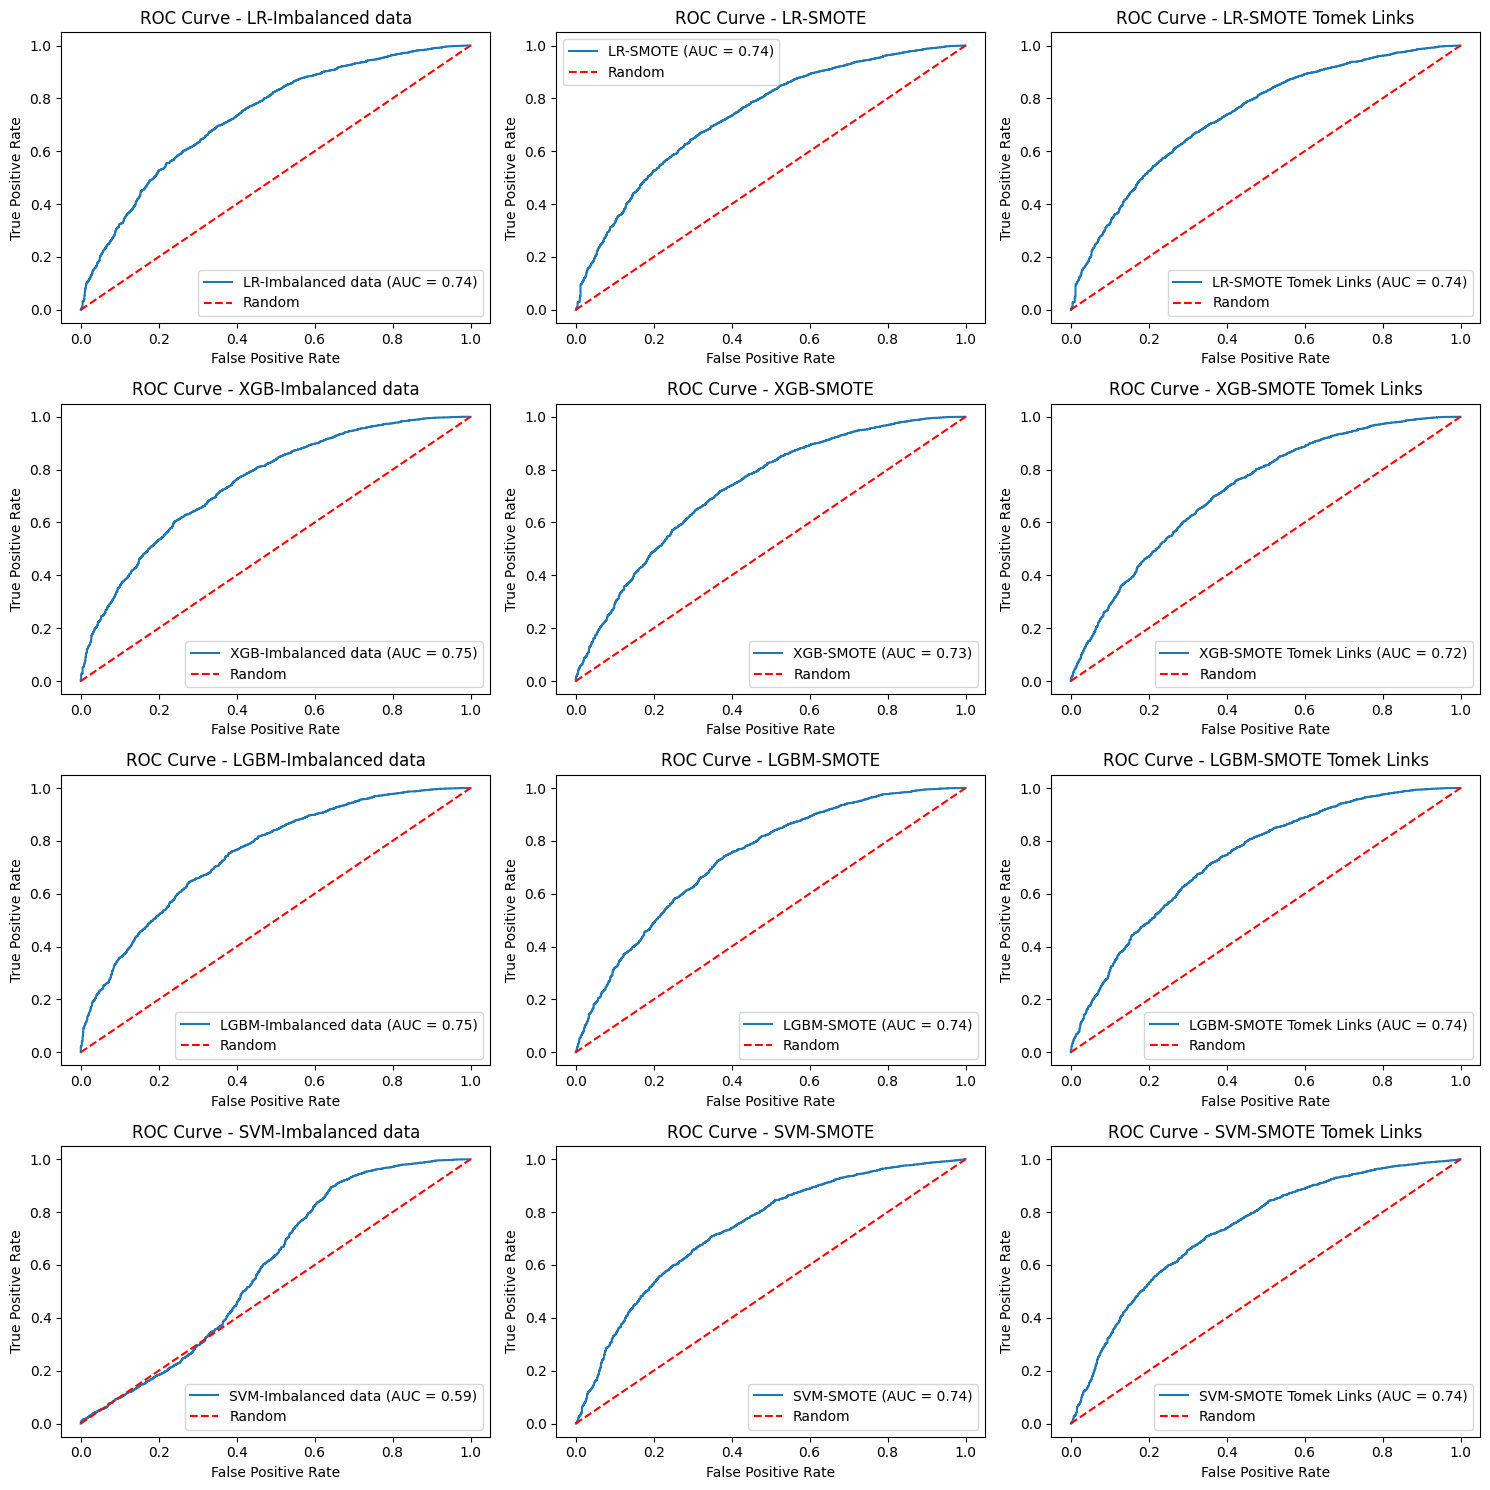

,Model,Accuracy,Precision (macro avg),Recall (macro avg),F1 (macro avg),Balanced accuracy,AUC,Precision (0),Precision (1),Recall (0),Recall (1),F1 (0),F1 (1),CM
LR-Imbalanced data,LR-Imbalanced data,0.89463,0.790965,0.526884,0.524596,0.526884,0.735501,0.685393,0.896538,0.056956,0.996811,0.105172,0.944019,"[[61, 1010], [28, 8752]]"
LR-SMOTE,LR-SMOTE,0.68054,0.572678,0.67158,0.551087,0.67158,0.737686,0.202579,0.942776,0.660131,0.68303,0.31002,0.792154,"[[707, 364], [2783, 5997]]"
LR-SMOTE Tomek Links,LR-SMOTE Tomek Links,0.681352,0.573256,0.672856,0.551953,0.672856,0.737617,0.203385,0.943126,0.661998,0.683713,0.31117,0.792737,"[[709, 362], [2777, 6003]]"
XGB-Imbalanced data,XGB-Imbalanced data,0.898284,0.811837,0.549839,0.564238,0.549839,0.752005,0.722581,0.901093,0.104575,0.995103,0.182708,0.945767,"[[112, 959], [43, 8737]]"
XGB-SMOTE,XGB-SMOTE,0.892295,0.710323,0.566154,0.586902,0.566154,0.730778,0.516129,0.904517,0.149393,0.982916,0.231716,0.942088,"[[160, 911], [150, 8630]]"
XGB-SMOTE Tomek Links,XGB-SMOTE Tomek Links,0.891382,0.703224,0.568101,0.589167,0.568101,0.724249,0.501511,0.904937,0.154995,0.981207,0.236805,0.94153,"[[166, 905], [165, 8615]]"
LGBM-Imbalanced data,LGBM-Imbalanced data,0.897168,0.78784,0.549212,0.563111,0.549212,0.752001,0.674699,0.900981,0.104575,0.99385,0.181083,0.945139,"[[112, 959], [54, 8726]]"
LGBM-SMOTE,LGBM-SMOTE,0.892498,0.711771,0.587173,0.613411,0.587173,0.735493,0.514634,0.908908,0.197012,0.977335,0.284943,0.94188,"[[211, 860], [199, 8581]]"
LGBM-SMOTE Tomek Links,LGBM-SMOTE Tomek Links,0.890366,0.699733,0.589667,0.615037,0.589667,0.736369,0.489978,0.909487,0.205415,0.973918,0.289474,0.940601,"[[220, 851], [229, 8551]]"
SVM-Imbalanced data,SVM-Imbalanced data,0.894731,0.839374,0.521202,0.513636,0.521202,0.59088,0.783333,0.895414,0.043884,0.998519,0.083112,0.94416,"[[47, 1024], [13, 8767]]"


In [11]:
results = {}
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

pipeline_list =[('LR-Imbalanced data',pipe_lr_imb),('LR-SMOTE', pipe_lr_os),('LR-SMOTE Tomek Links', pipe_lr_hybrid),
    ('XGB-Imbalanced data', pipe_xgb_imb), ('XGB-SMOTE', pipe_xgb_os),('XGB-SMOTE Tomek Links', pipe_xgb_hybrid),
    ('LGBM-Imbalanced data',pipe_lgbm_imb),('LGBM-SMOTE', pipe_lgbm_os),('LGBM-SMOTE Tomek Links', pipe_lgbm_hybrid),       
    ('SVM-Imbalanced data',pipe_svm_imb), ('SVM-SMOTE', pipe_svm_os), ('SVM-SMOTE Tomek Links', pipe_svm_hybrid)
                 ]
for idx,(name, pipe) in enumerate(pipeline_list):
    ## For each model, match the pipeline in pipeline_list with the best_params in best_params_df
    param = params_df[params_df['model']==name]['best_params'].iloc[0]
    pipe.set_params(**param)
    ## Predict on the test set
    pipe.fit(X_train_df, y_train)
    y_test_pred = pipe.predict(X_test_df)
    y_test_pred_proba = pipe.predict_proba(X_test_df)

    ## Evaluation metrics
    auc_test = roc_auc_score(y_test, y_test_pred_proba[:, 1])
    clf_report = classification_report(y_test, y_test_pred,output_dict=True)
    class0_metrics = clf_report['0']
    class1_metrics = clf_report['1']
    macro_avg_metrics = clf_report['macro avg']
    accuracy_metric = clf_report['accuracy']
    balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

    ##  Store the results
    metrics_dict = {'Model':name,
                    'Accuracy':accuracy_metric,
                    'Precision (macro avg)':macro_avg_metrics['precision'],
                     'Recall (macro avg)':macro_avg_metrics['recall'],
                     'F1 (macro avg)':macro_avg_metrics['f1-score'],
                     'Balanced accuracy': balanced_acc,
                      'AUC': auc_test,
                     
                     'Precision (0)':class0_metrics['precision'],
                      'Precision (1)':class1_metrics['precision'],
                              
                      'Recall (0)':class0_metrics['recall'],
                      'Recall (1)':class1_metrics['recall'],
                              
                      'F1 (0)':class0_metrics['f1-score'],
                      'F1 (1)':class1_metrics['f1-score'],
                      'CM':confusion_matrix(y_test, y_test_pred),
                      
                              }
    results[name]=metrics_dict

    ##Visualize ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba[:, 1])
    auc_test = roc_auc_score(y_test, y_test_pred_proba[:, 1])

    ax = axs[idx // 3, idx % 3]
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc_test:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {name}')
    ax.legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results).T
results_df


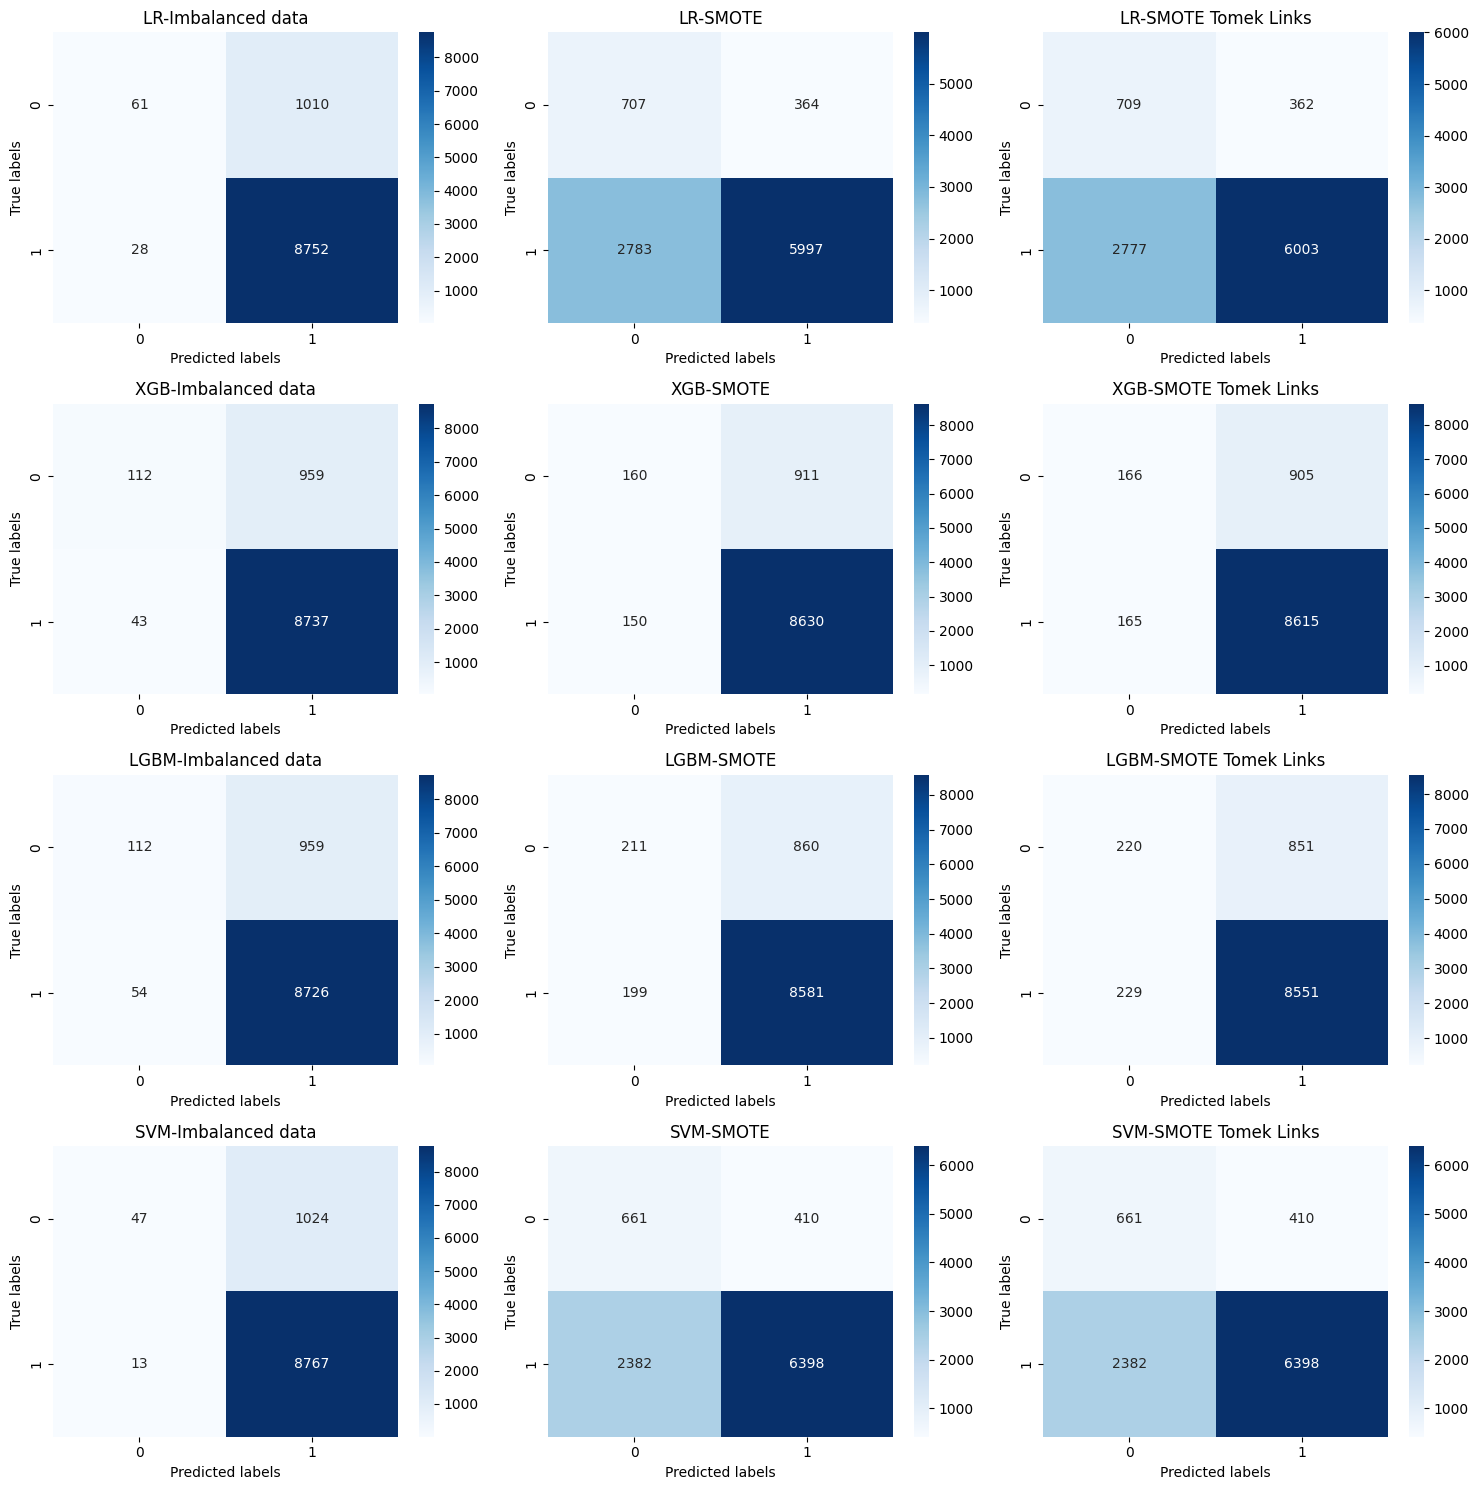

In [12]:

fig_cm, axs_cm = plt.subplots(4, 3, figsize=(15, 15))

for idx, (name, pipe) in enumerate(pipeline_list):

    ax_cm = axs_cm[idx // 3, idx % 3]
    sns.heatmap(results[name]['CM'], annot=True, cmap='Blues', fmt='g', ax=ax_cm)
    ax_cm.set_title(f'{name}')
    ax_cm.set_xlabel('Predicted labels')
    ax_cm.set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [13]:
results_df[['Model','F1 (1)','AUC','Accuracy','Precision (1)','Recall (1)']]


,Model,F1 (1),AUC,Accuracy,Precision (1),Recall (1)
LR-Imbalanced data,LR-Imbalanced data,0.944019,0.735501,0.89463,0.896538,0.996811
LR-SMOTE,LR-SMOTE,0.792154,0.737686,0.68054,0.942776,0.68303
LR-SMOTE Tomek Links,LR-SMOTE Tomek Links,0.792737,0.737617,0.681352,0.943126,0.683713
XGB-Imbalanced data,XGB-Imbalanced data,0.945767,0.752005,0.898284,0.901093,0.995103
XGB-SMOTE,XGB-SMOTE,0.942088,0.730778,0.892295,0.904517,0.982916
XGB-SMOTE Tomek Links,XGB-SMOTE Tomek Links,0.94153,0.724249,0.891382,0.904937,0.981207
LGBM-Imbalanced data,LGBM-Imbalanced data,0.945139,0.752001,0.897168,0.900981,0.99385
LGBM-SMOTE,LGBM-SMOTE,0.94188,0.735493,0.892498,0.908908,0.977335
LGBM-SMOTE Tomek Links,LGBM-SMOTE Tomek Links,0.940601,0.736369,0.890366,0.909487,0.973918
SVM-Imbalanced data,SVM-Imbalanced data,0.94416,0.59088,0.894731,0.895414,0.998519


In [14]:
results_df.to_csv('output/metrics_results.csv',index=False)
results_df = pd.read_csv('output/metrics_results.csv')
results_df

,Model,Accuracy,Precision (macro avg),Recall (macro avg),F1 (macro avg),Balanced accuracy,AUC,Precision (0),Precision (1),Recall (0),Recall (1),F1 (0),F1 (1),CM
0,LR-Imbalanced data,0.894630,0.790965,0.526884,0.524596,0.526884,0.735501,0.685393,0.896538,0.056956,0.996811,0.105172,0.944019,[[ 61 1010]\n [ 28 8752]]
1,LR-SMOTE,0.680540,0.572678,0.671580,0.551087,0.671580,0.737686,0.202579,0.942776,0.660131,0.683030,0.310020,0.792154,[[ 707 364]\n [2783 5997]]
2,LR-SMOTE Tomek Links,0.681352,0.573256,0.672856,0.551953,0.672856,0.737617,0.203385,0.943126,0.661998,0.683713,0.311170,0.792737,[[ 709 362]\n [2777 6003]]
3,XGB-Imbalanced data,0.898284,0.811837,0.549839,0.564238,0.549839,0.752005,0.722581,0.901093,0.104575,0.995103,0.182708,0.945767,[[ 112 959]\n [ 43 8737]]
4,XGB-SMOTE,0.892295,0.710323,0.566154,0.586902,0.566154,0.730778,0.516129,0.904517,0.149393,0.982916,0.231716,0.942088,[[ 160 911]\n [ 150 8630]]
5,XGB-SMOTE Tomek Links,0.891382,0.703224,0.568101,0.589167,0.568101,0.724249,0.501511,0.904937,0.154995,0.981207,0.236805,0.941530,[[ 166 905]\n [ 165 8615]]
6,LGBM-Imbalanced data,0.897168,0.787840,0.549212,0.563111,0.549212,0.752001,0.674699,0.900981,0.104575,0.993850,0.181083,0.945139,[[ 112 959]\n [ 54 8726]]
7,LGBM-SMOTE,0.892498,0.711771,0.587173,0.613411,0.587173,0.735493,0.514634,0.908908,0.197012,0.977335,0.284943,0.941880,[[ 211 860]\n [ 199 8581]]
8,LGBM-SMOTE Tomek Links,0.890366,0.699733,0.589667,0.615037,0.589667,0.736369,0.489978,0.909487,0.205415,0.973918,0.289474,0.940601,[[ 220 851]\n [ 229 8551]]
9,SVM-Imbalanced data,0.894731,0.839374,0.521202,0.513636,0.521202,0.590880,0.783333,0.895414,0.043884,0.998519,0.083112,0.944160,[[ 47 1024]\n [ 13 8767]]
